### Klasyfikacja ręcznie rysowanych i zdigitalizowanych obrazków

Celem tego zadania jest zbudowanie i ocena modelu uczenia maszynowego do klasyfikacji prostych, ręcznie rysowanych obrazków. Zadanie polega na przetworzeniu i analizie zbioru danych zawierającego 10 różnych klas obiektów, z których każda reprezentowana jest przez trzy typy obrazów: rysowane i fotografowane, rysowane i skanowane oraz tworzone za pomocą stempli i fotografowane.

Projekt zostanie zrealizowany w czterech głównych etapach:
1.  **Eksploracja danych:** zapoznanie się ze zbiorem danych, jego strukturą, rozkładem klas i potencjalnymi problemami
2.  **Preprocessing:** przygotowanie obrazów do treningu modelu, w tym normalizacja danych
3.  **Modelowanie:** zbudowanie, wytrenowanie i porównanie trzech różnych architektur sieci konwolucyjnych (CNN)
4.  **Ewaluacja:** ocena wydajności modeli przy użyciu odpowiednich metryk i analiza wyników

##### 1. Eksploracja danych
Na tym etapie ładujemy zbiór danych i przeprowadzamy jego wstępną analizę. Naszym celem jest zrozumienie jego podstawowych cech, takich jak liczba klas, liczba obrazków w każdej klasie oraz wizualna prezentacja próbek. Pozwoli nam to zidentyfikować potencjalne problemy, takie jak niezbalansowanie klas, które mogłyby wpłynąć na proces trenowania modelu.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import random
import collections
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# ładowanie datasetu
full_ds = torchvision.datasets.ImageFolder(root="data")
class_names = full_ds.classes
num_classes = len(class_names)

print(f"Liczba obrazków: {len(full_ds)}")
print("Liczba klas:", num_classes)

Liczba obrazków: 431
Liczba klas: 10


**Podział na zbiór treningowy i testowy**

Kluczowym krokiem jest podział danych na zbiór treningowy i testowy. Zbiór testowy zostanie całkowicie wyłączony z dalszej analizy i procesu trenowania. Użyjemy podziału 80/20, gdzie 80% danych posłuży do trenowania i walidacji, a pozostałe 20% do testowania.

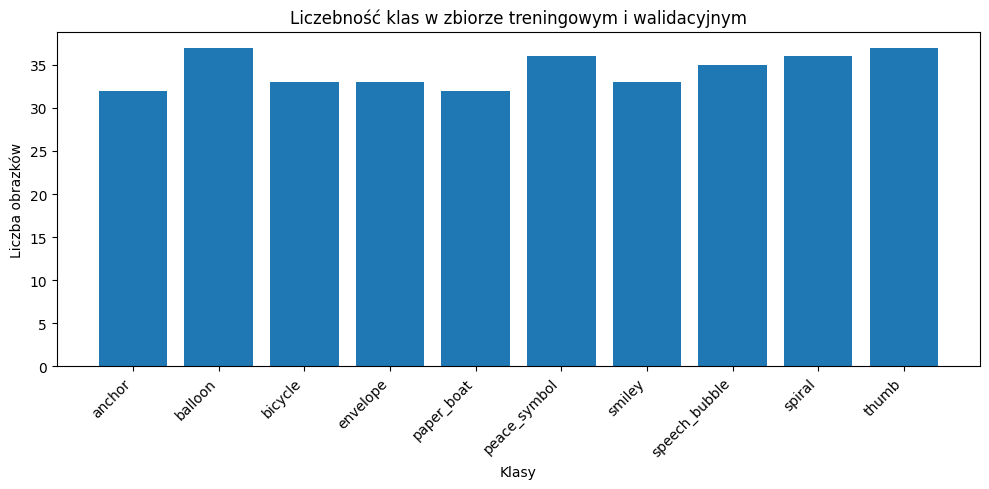

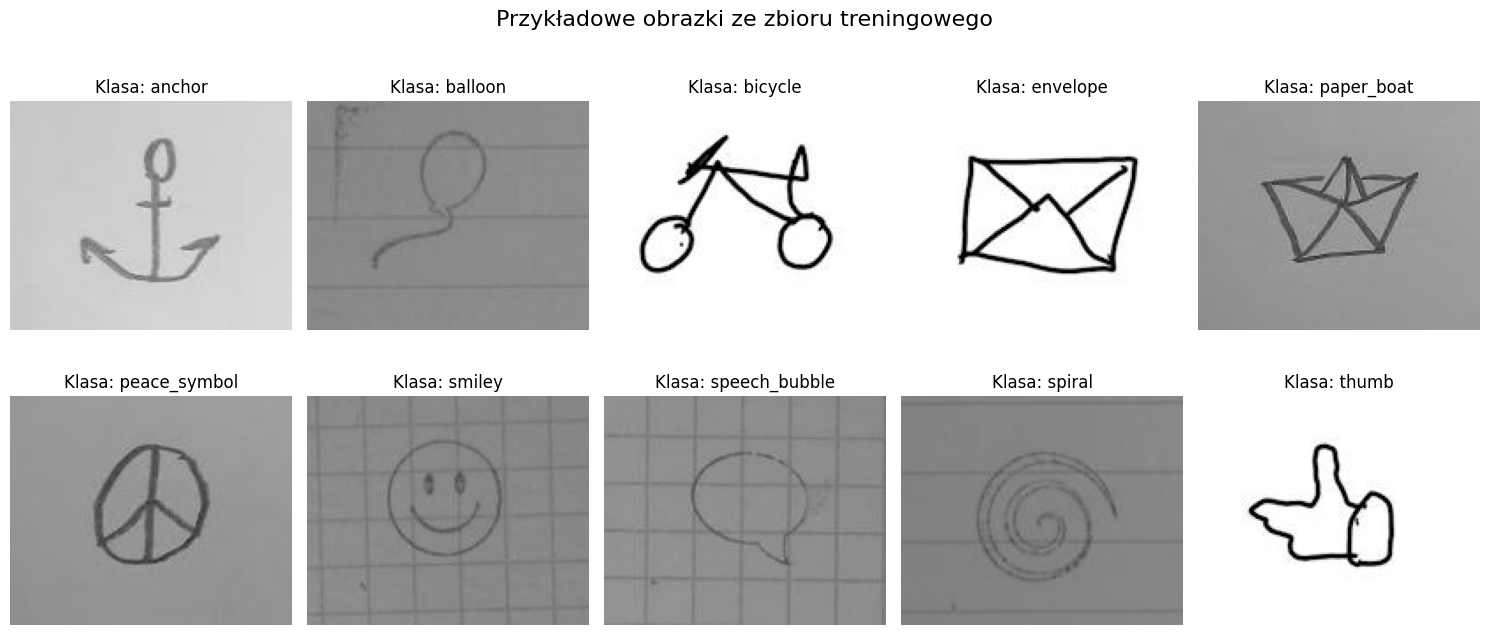

In [34]:
# dzielenie datasetu na train i test
train_val_size = int(0.8 * len(full_ds))
test_size = len(full_ds) - train_val_size
train_val_ds, test_ds = torch.utils.data.random_split(full_ds, [train_val_size, test_size])
train_val_targets = np.array(full_ds.targets)[train_val_ds.indices]

# badanie zrównoważenia klas w zbiorze treningowym
class_counter = collections.Counter(train_val_targets)

plt.figure(figsize=(10, 5))
plt.bar(class_counter.keys(), class_counter.values())
plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.xlabel("Klasy")
plt.ylabel("Liczba obrazków")
plt.title("Liczebność klas w zbiorze treningowym i walidacyjnym")
plt.tight_layout()
plt.savefig("figures/liczebnosc-klas.png")
plt.show()

# wizualizacja zbioru treningowego
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
fig.suptitle("Przykładowe obrazki ze zbioru treningowego", fontsize=16)
for i, class_name in enumerate(class_names):
    class_idx = full_ds.class_to_idx[class_name]
    target_ixs = np.where(train_val_targets == class_idx)[0]
    
    ix = random.choice(target_ixs)
    img, label = train_val_ds[ix]
    
    ax = axes.flat[i]
    ax.imshow(img)
    ax.set_title(f"Klasa: {class_name}")
    ax.axis('off')

# zapisywanie wizualizacji
plt.tight_layout()
plt.savefig("figures/ds-wizualizacja.png")

**Wnioski z przeprowadzonej eksploracji danych** 

Jak widać na powyższym wykresie, zbiór treningowy jest stosunkowo dobrze zbalansowany. Liczba obrazków w poszczególnych klasach jest do siebie zbliżona, co jest korzystne dla procesu uczenia i zmniejsza ryzyko, że model będzie faworyzował klasy liczniejsze.

#### 2. Preprocessing 

W tym etapie surowe obrazki (w formacie PIL) zostaną przekształcone do postaci tensorów. Ponadto, przeprowadzimy normalizację, która polega na przeskalowaniu wartości pikseli tak, aby miały średnią równą 0 i odchylenie standardowe równe 1. Obliczymy średnią i odchylenie standardowe na podstawie zbioru treningowego, aby uniknąć wycieku informacji ze zbioru testowego.

In [4]:
train_val_ds_for_calc = torchvision.datasets.ImageFolder(root="data", transform=torchvision.transforms.ToTensor())
train_val_ds_for_calc = torch.utils.data.Subset(train_val_ds_for_calc, train_val_ds.indices)

calc_loader = torch.utils.data.DataLoader(train_val_ds_for_calc, batch_size=64)

mean = 0
std = 0
n_samples = 0

for images_batch, labels_batch in calc_loader:
    images_flat = images_batch.view(images_batch.size(0), images_batch.size(1), -1)

    mean += images_flat.mean(2).sum(0)
    std += images_flat.std(2).sum(0)
    n_samples += images_batch.size(0)

mean /= n_samples
std /= n_samples

print(f"Obliczone wartości dla zbioru treningowego:")
print(f"Średnia: {mean}")
print(f"Odchylenie standardowe: {std}")

Obliczone wartości dla zbioru treningowego:
Średnia: tensor([0.7494, 0.7494, 0.7494])
Odchylenie standardowe: tensor([0.1037, 0.1037, 0.1037])


Zdefiniujemy dwie różne ścieżki transformacji obrazów:

1.  **Transformacja standardowa (`transform_norm`):** Używana dla naszych własnych, prostych modeli CNN. Obejmuje konwersję do tensora i normalizację z wykorzystaniem obliczonych wcześniej statystyk.

2.  **Transformacja dla modelu pretrained (`transform_pretrained`):** Używana dla modelu ResNet18. Oprócz konwersji do tensora, obrazy są skalowane do rozmiaru 224x224, a normalizacja odbywa się z użyciem standardowych wartości dla zbioru ImageNet, na którym model był pierwotnie trenowany.
```

In [5]:
# normalizacja zbioru dla modelu 1 i 2
transform_norm = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean=mean, std=std)])

# normalizacja zbioru dla modelu 3 (ResNet18)
transform_pretrained = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# tworzenie zbiorów dla modeli 1 i 2
full_ds_norm = torchvision.datasets.ImageFolder(root="data", transform=transform_norm)
train_val_ds_norm = torch.utils.data.Subset(full_ds_norm, train_val_ds.indices)
test_ds_norm = torch.utils.data.Subset(full_ds_norm, test_ds.indices)

# tworzenie zbiorów dla modelu 3 (ResNet18)
full_ds_pretrained = torchvision.datasets.ImageFolder(root="data", transform=transform_pretrained)
train_val_ds_pretrained = torch.utils.data.Subset(full_ds_pretrained, train_val_ds.indices)
test_ds_pretrained = torch.utils.data.Subset(full_ds_pretrained, test_ds.indices)

#### 3. Modele

W tej części zdefiniujemy, wytrenujemy i porównamy trzy różne architektury sieci konwolucyjnych, ponieważ są one standardem w problemach związanych z przetwarzaniem i klasyfikacją obrazów. Zaczniemy od prostego modelu CNN, następnie wprowadzimy ulepszenia w postaci batch normalization i dropoutu, a na końcu wykorzystamy architekturę ResNet18. Jako funkcję straty wybieramy `CrossEntropyLoss`, a jako optymalizator znany i lubiany - optymalizator `Adam`.

- **Model 1 (CNN1)**: Prosta sieć z trzema warstwami konwolucyjnymi, każda z nich jest połączona z warstwą max-pooling, a następnie z warstwą w pełni połączoną

In [6]:
# model 1
class CNN1(torch.nn.Module):

    def __init__(self, input_size, num_classes):
        super(CNN1, self).__init__()

        self.conv_block1 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=input_size, out_channels=16, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        

        self.conv_block3 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=32, out_channels=40, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = torch.nn.Linear(40 * 16 * 20, num_classes)

    def forward(self, x):

        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)

        return x
    
model1 = CNN1(input_size=3, num_classes=len(class_names))

# optimizer hyperparameters
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)

* **Model 2 (CNN2):** To rozbudowana wersja pierwszego. Do każdego bloku konwolucyjnego dodajemy warstwę `BatchNorm2d`, która stabilizuje i przyspiesza proces uczenia. Przed warstwą klasyfikującą dodajemy również warstwę `Dropout` z prawdopodobieństwem 0.5

In [7]:
# model 2
class CNN2(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN2, self).__init__()

        self.conv_block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=input_size, out_channels=16, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(48),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(48 * 16 * 20, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.classifier(x)
        return x

model2 = CNN2(input_size=3, num_classes=len(class_names))

# optimizer hyperparameters
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

* **Model 3:** Trzecie podejście to transfer learning. Wykorzystujemy wytrenowany wcześniej model ResNet18. "Zamrażamy" wagi wszystkich warstw konwolucyjnych, aby zachować wiedzę zdobytą na ImageNet, a następnie zastępujemy oryginalną warstwę klasyfikującą nową, dostosowaną do naszego problemu (10 klas).

In [8]:
# model 3
model3 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

for param in model3.parameters():
    param.requires_grad = False

num_ftrs = model3.fc.in_features
print(num_ftrs)
model3.fc = torch.nn.Linear(num_ftrs, num_classes)

optimizer3 = torch.optim.Adam(model3.fc.parameters(), lr=0.001)

512


In [9]:
epochs = 30
criterion = torch.nn.CrossEntropyLoss()

val_size = int(0.2 * len(train_val_ds))
train_size = len(train_val_ds) - val_size

# tworzenie loaderów dla modeli 1 i 2
train_ds_norm, val_ds_norm = torch.utils.data.random_split(train_val_ds_norm, [train_size, val_size])

train_loader_norm = torch.utils.data.DataLoader(train_ds_norm, batch_size=64, shuffle=True)
val_loader_norm = torch.utils.data.DataLoader(val_ds_norm, batch_size=64, shuffle=False)
test_loader_norm = torch.utils.data.DataLoader(test_ds_norm, batch_size=64, shuffle=False)

# te same indeksy dla modelu 3
train_idx, val_idx = train_ds_norm.indices, val_ds_norm.indices

# tworzenie loaderów dla modelu 3 (ResNet18)
train_ds_pretrained = torch.utils.data.Subset(train_val_ds_pretrained, train_idx)
val_ds_pretrained = torch.utils.data.Subset(train_val_ds_pretrained, val_idx)

train_loader_pretrained = torch.utils.data.DataLoader(train_ds_pretrained, batch_size=64, shuffle=True)
val_loader_pretrained = torch.utils.data.DataLoader(val_ds_pretrained, batch_size=64, shuffle=False)
test_loader_pretrained = torch.utils.data.DataLoader(test_ds_pretrained, batch_size=64, shuffle=False)


print(f"Wielkość zbioru treningowego: {len(train_ds_norm)}")
print(f"Wielkość zbioru walidacyjnego: {len(val_ds_norm)}")
print(f"Wielkość zbioru testowego: {len(test_ds_norm)}")


Wielkość zbioru treningowego: 276
Wielkość zbioru walidacyjnego: 68
Wielkość zbioru testowego: 87


In [10]:
# training loop model 1
for epoch in range(epochs):
    model1.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader_norm):
        outputs = model1(images)
        loss = criterion(outputs, labels)

        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        train_loss += loss.item()
    
    model1.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader_norm):
            outputs = model1(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader_norm):.4f}, Val Loss: {val_loss/len(val_loader_norm):.4f}")

100%|██████████| 2/2 [00:00<00:00, 17.44it/s]


Epoch [1/30], Train Loss: 2.3166, Val Loss: 2.1612


100%|██████████| 2/2 [00:00<00:00, 16.82it/s]


Epoch [2/30], Train Loss: 1.7894, Val Loss: 1.7446


100%|██████████| 2/2 [00:00<00:00, 16.36it/s]


Epoch [3/30], Train Loss: 1.2029, Val Loss: 2.1886


100%|██████████| 2/2 [00:00<00:00, 15.77it/s]


Epoch [4/30], Train Loss: 1.1333, Val Loss: 1.8003


100%|██████████| 2/2 [00:00<00:00, 17.31it/s]


Epoch [5/30], Train Loss: 0.8865, Val Loss: 1.3546


100%|██████████| 2/2 [00:00<00:00, 16.72it/s]


Epoch [6/30], Train Loss: 0.6896, Val Loss: 1.2271


100%|██████████| 2/2 [00:00<00:00, 15.04it/s]


Epoch [7/30], Train Loss: 0.5229, Val Loss: 1.2146


100%|██████████| 2/2 [00:00<00:00, 17.86it/s]


Epoch [8/30], Train Loss: 0.4456, Val Loss: 1.2467


100%|██████████| 2/2 [00:00<00:00, 15.61it/s]


Epoch [9/30], Train Loss: 0.3928, Val Loss: 1.2705


100%|██████████| 2/2 [00:00<00:00, 16.98it/s]


Epoch [10/30], Train Loss: 0.3114, Val Loss: 1.2890


100%|██████████| 2/2 [00:00<00:00, 15.72it/s]


Epoch [11/30], Train Loss: 0.2632, Val Loss: 0.9472


100%|██████████| 2/2 [00:00<00:00, 17.56it/s]


Epoch [12/30], Train Loss: 0.1733, Val Loss: 0.9822


100%|██████████| 2/2 [00:00<00:00, 17.33it/s]


Epoch [13/30], Train Loss: 0.1630, Val Loss: 0.9760


100%|██████████| 2/2 [00:00<00:00, 15.82it/s]


Epoch [14/30], Train Loss: 0.1251, Val Loss: 0.9080


100%|██████████| 2/2 [00:00<00:00, 17.09it/s]


Epoch [15/30], Train Loss: 0.1168, Val Loss: 1.7178


100%|██████████| 2/2 [00:00<00:00, 17.55it/s]


Epoch [16/30], Train Loss: 0.2676, Val Loss: 1.2164


100%|██████████| 2/2 [00:00<00:00, 17.39it/s]


Epoch [17/30], Train Loss: 0.1460, Val Loss: 0.8685


100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


Epoch [18/30], Train Loss: 0.0735, Val Loss: 0.9095


100%|██████████| 2/2 [00:00<00:00, 16.32it/s]


Epoch [19/30], Train Loss: 0.0940, Val Loss: 1.0383


100%|██████████| 2/2 [00:00<00:00, 17.13it/s]


Epoch [20/30], Train Loss: 0.0492, Val Loss: 1.0193


100%|██████████| 2/2 [00:00<00:00, 15.63it/s]


Epoch [21/30], Train Loss: 0.0409, Val Loss: 0.9145


100%|██████████| 2/2 [00:00<00:00, 17.23it/s]


Epoch [22/30], Train Loss: 0.0213, Val Loss: 0.9572


100%|██████████| 2/2 [00:00<00:00, 17.65it/s]


Epoch [23/30], Train Loss: 0.0165, Val Loss: 1.0288


100%|██████████| 2/2 [00:00<00:00, 17.79it/s]


Epoch [24/30], Train Loss: 0.0143, Val Loss: 0.9922


100%|██████████| 2/2 [00:00<00:00, 15.85it/s]


Epoch [25/30], Train Loss: 0.0155, Val Loss: 1.2952


100%|██████████| 2/2 [00:00<00:00, 17.05it/s]


Epoch [26/30], Train Loss: 0.0191, Val Loss: 1.1355


100%|██████████| 2/2 [00:00<00:00, 17.22it/s]


Epoch [27/30], Train Loss: 0.0349, Val Loss: 1.1693


100%|██████████| 2/2 [00:00<00:00, 15.02it/s]


Epoch [28/30], Train Loss: 0.0383, Val Loss: 1.1345


100%|██████████| 2/2 [00:00<00:00, 16.94it/s]


Epoch [29/30], Train Loss: 0.0187, Val Loss: 1.1884


100%|██████████| 2/2 [00:00<00:00, 17.29it/s]

Epoch [30/30], Train Loss: 0.0184, Val Loss: 1.1571


In [11]:
# training loop model 2
for epoch in range(epochs):
    model2.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader_norm):
        outputs = model2(images)
        loss = criterion(outputs, labels)

        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        train_loss += loss.item()
    model2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader_norm):
            outputs = model2(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader_norm):.4f}, Val Loss: {val_loss/len(val_loader_norm):.4f}")



100%|██████████| 2/2 [00:00<00:00, 14.71it/s]


Epoch [1/30], Train Loss: 3.8629, Val Loss: 2.2165


100%|██████████| 2/2 [00:00<00:00, 14.39it/s]


Epoch [2/30], Train Loss: 2.2337, Val Loss: 1.9010


100%|██████████| 2/2 [00:00<00:00, 13.19it/s]


Epoch [3/30], Train Loss: 1.1227, Val Loss: 1.8046


100%|██████████| 2/2 [00:00<00:00, 16.04it/s]


Epoch [4/30], Train Loss: 0.9088, Val Loss: 1.4742


100%|██████████| 2/2 [00:00<00:00, 16.37it/s]


Epoch [5/30], Train Loss: 0.5765, Val Loss: 1.1595


100%|██████████| 2/2 [00:00<00:00, 14.53it/s]


Epoch [6/30], Train Loss: 0.4356, Val Loss: 1.2306


100%|██████████| 2/2 [00:00<00:00, 14.12it/s]


Epoch [7/30], Train Loss: 0.3800, Val Loss: 1.0384


100%|██████████| 2/2 [00:00<00:00, 11.98it/s]


Epoch [8/30], Train Loss: 0.2812, Val Loss: 0.9207


100%|██████████| 2/2 [00:00<00:00, 16.07it/s]


Epoch [9/30], Train Loss: 0.2517, Val Loss: 0.9704


100%|██████████| 2/2 [00:00<00:00, 11.03it/s]


Epoch [10/30], Train Loss: 0.2226, Val Loss: 1.0326


100%|██████████| 2/2 [00:00<00:00, 15.33it/s]


Epoch [11/30], Train Loss: 0.1922, Val Loss: 0.9565


100%|██████████| 2/2 [00:00<00:00, 15.62it/s]


Epoch [12/30], Train Loss: 0.1675, Val Loss: 0.8104


100%|██████████| 2/2 [00:00<00:00, 15.68it/s]


Epoch [13/30], Train Loss: 0.1399, Val Loss: 0.9264


100%|██████████| 2/2 [00:00<00:00, 16.40it/s]


Epoch [14/30], Train Loss: 0.1173, Val Loss: 1.0012


100%|██████████| 2/2 [00:00<00:00, 14.06it/s]


Epoch [15/30], Train Loss: 0.0974, Val Loss: 0.8621


100%|██████████| 2/2 [00:00<00:00, 14.34it/s]


Epoch [16/30], Train Loss: 0.0888, Val Loss: 0.7683


100%|██████████| 2/2 [00:00<00:00,  9.81it/s]


Epoch [17/30], Train Loss: 0.0827, Val Loss: 0.7889


100%|██████████| 2/2 [00:00<00:00, 13.73it/s]


Epoch [18/30], Train Loss: 0.0612, Val Loss: 0.8270


100%|██████████| 2/2 [00:00<00:00, 15.13it/s]


Epoch [19/30], Train Loss: 0.0570, Val Loss: 0.8683


100%|██████████| 2/2 [00:00<00:00, 16.03it/s]


Epoch [20/30], Train Loss: 0.0520, Val Loss: 0.8094


100%|██████████| 2/2 [00:00<00:00, 14.95it/s]


Epoch [21/30], Train Loss: 0.0434, Val Loss: 0.6873


100%|██████████| 2/2 [00:00<00:00, 16.40it/s]


Epoch [22/30], Train Loss: 0.0446, Val Loss: 0.7181


100%|██████████| 2/2 [00:00<00:00, 14.92it/s]


Epoch [23/30], Train Loss: 0.0395, Val Loss: 0.7875


100%|██████████| 2/2 [00:00<00:00, 15.35it/s]


Epoch [24/30], Train Loss: 0.0331, Val Loss: 0.7442


100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


Epoch [25/30], Train Loss: 0.0300, Val Loss: 0.7192


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


Epoch [26/30], Train Loss: 0.0256, Val Loss: 0.6723


100%|██████████| 2/2 [00:00<00:00, 15.08it/s]


Epoch [27/30], Train Loss: 0.0248, Val Loss: 0.7221


100%|██████████| 2/2 [00:00<00:00, 15.97it/s]


Epoch [28/30], Train Loss: 0.0346, Val Loss: 0.7181


100%|██████████| 2/2 [00:00<00:00, 15.63it/s]


Epoch [29/30], Train Loss: 0.0289, Val Loss: 0.6616


100%|██████████| 2/2 [00:00<00:00, 16.01it/s]

Epoch [30/30], Train Loss: 0.0366, Val Loss: 0.5617


In [12]:
# training loop model 3
epochs = 30
for epoch in range(epochs):
    model3.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader_pretrained):
        outputs = model3(images)
        loss = criterion(outputs, labels)

        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()
        train_loss += loss.item()
    model3.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader_pretrained):
            outputs = model3(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader_pretrained):.4f}, Val Loss: {val_loss/len(val_loader_pretrained):.4f}")

100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Epoch [1/30], Train Loss: 2.3191, Val Loss: 2.4214


100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Epoch [2/30], Train Loss: 1.9541, Val Loss: 2.2324


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Epoch [3/30], Train Loss: 1.7276, Val Loss: 1.9586


100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Epoch [4/30], Train Loss: 1.4518, Val Loss: 1.7257


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Epoch [5/30], Train Loss: 1.2411, Val Loss: 1.5258


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch [6/30], Train Loss: 1.0996, Val Loss: 1.3702


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Epoch [7/30], Train Loss: 0.9210, Val Loss: 1.2486


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch [8/30], Train Loss: 0.7970, Val Loss: 1.1172


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Epoch [9/30], Train Loss: 0.7377, Val Loss: 0.9930


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Epoch [10/30], Train Loss: 0.6285, Val Loss: 0.9661


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Epoch [11/30], Train Loss: 0.6066, Val Loss: 0.8985


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Epoch [12/30], Train Loss: 0.5439, Val Loss: 0.8148


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Epoch [13/30], Train Loss: 0.4784, Val Loss: 0.7900


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Epoch [14/30], Train Loss: 0.4600, Val Loss: 0.7938


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Epoch [15/30], Train Loss: 0.3865, Val Loss: 0.7399


100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Epoch [16/30], Train Loss: 0.4209, Val Loss: 0.6796


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Epoch [17/30], Train Loss: 0.3822, Val Loss: 0.6490


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Epoch [18/30], Train Loss: 0.3244, Val Loss: 0.6781


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Epoch [19/30], Train Loss: 0.3222, Val Loss: 0.6475


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Epoch [20/30], Train Loss: 0.3017, Val Loss: 0.5965


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Epoch [21/30], Train Loss: 0.2811, Val Loss: 0.5830


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Epoch [22/30], Train Loss: 0.2918, Val Loss: 0.5983


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Epoch [23/30], Train Loss: 0.2604, Val Loss: 0.6148


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Epoch [24/30], Train Loss: 0.2504, Val Loss: 0.5707


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Epoch [25/30], Train Loss: 0.2258, Val Loss: 0.5152


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Epoch [26/30], Train Loss: 0.2293, Val Loss: 0.5031


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch [27/30], Train Loss: 0.2122, Val Loss: 0.5109


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch [28/30], Train Loss: 0.2062, Val Loss: 0.5348


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Epoch [29/30], Train Loss: 0.1888, Val Loss: 0.4834


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

Epoch [30/30], Train Loss: 0.1760, Val Loss: 0.4687


#### 4. Ewaluacja modeli

Na tym etapie oceniamy ostateczną skuteczność modeli na zbiorze testowym. Celem jest weryfikacja, jak dobrze modele generalizują wiedzę na nowe dane.

Wybrane metryki:

*   **Raport klasyfikacji:** zamiast samej dokładności (Accuracy), analizujemy też inne metryki:
    *   **Precision**
    *   **Recall**
    *   **F1-Score**

*   **Confusion matrix:** pokazuje, które klasy są ze sobą najczęściej mylone

In [13]:
def evaluate_model(model, dataloader, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
            
    print(f"--- Ewaluacja dla: {model_name} ---")
    
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nRaport klasyfikacji:")
    print(report)
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Przewidziana etykieta')
    plt.ylabel('Prawdziwa etykieta')
    plt.title(f'Confusion matrix dla {model_name}')
    plt.savefig(f"figures/{model_name.replace(" ", "_").lower()}.png")
    plt.show()

--- Ewaluacja dla: Model 1 (CNN1) ---

Raport klasyfikacji:
               precision    recall  f1-score   support

       anchor       1.00      0.90      0.95        10
      balloon       1.00      0.75      0.86         8
      bicycle       1.00      0.73      0.84        11
     envelope       0.64      1.00      0.78         9
   paper_boat       1.00      0.67      0.80         6
 peace_symbol       0.69      0.82      0.75        11
       smiley       0.80      0.67      0.73        12
speech_bubble       0.88      1.00      0.93         7
       spiral       0.75      0.75      0.75         4
        thumb       0.82      1.00      0.90         9

     accuracy                           0.83        87
    macro avg       0.86      0.83      0.83        87
 weighted avg       0.86      0.83      0.83        87



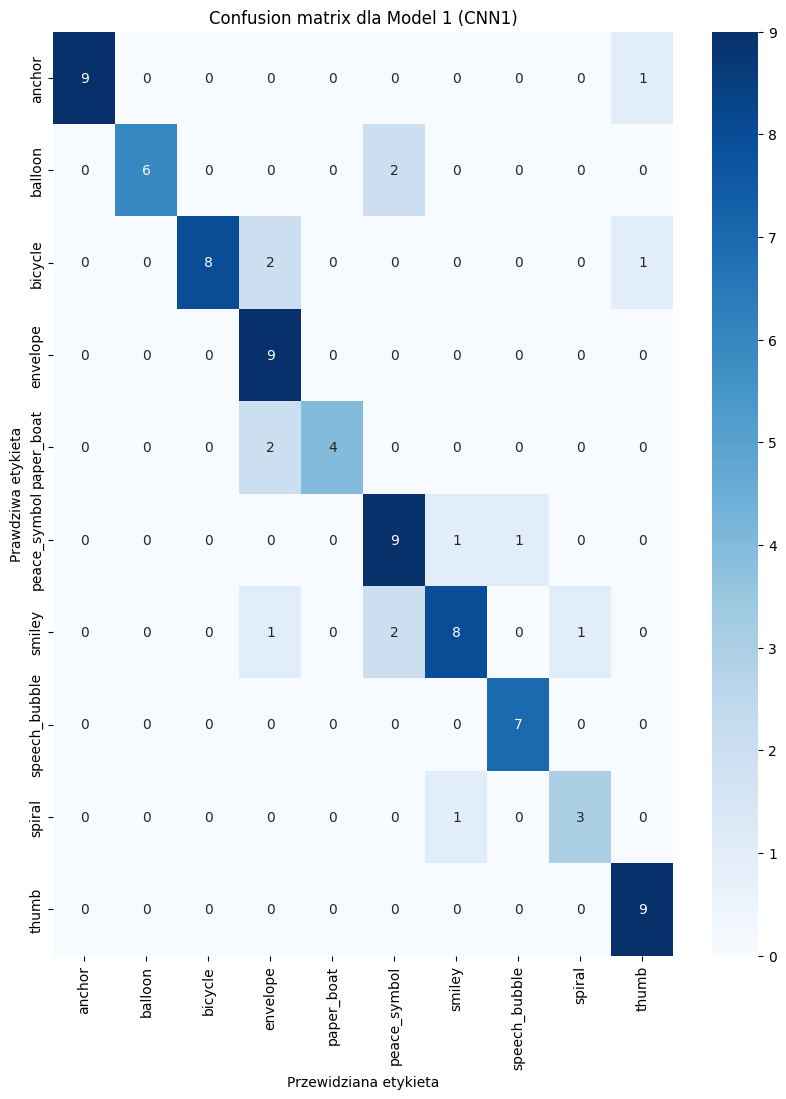

--- Ewaluacja dla: Model 2 (CNN2) ---

Raport klasyfikacji:
               precision    recall  f1-score   support

       anchor       1.00      1.00      1.00        10
      balloon       1.00      0.88      0.93         8
      bicycle       1.00      0.91      0.95        11
     envelope       1.00      0.89      0.94         9
   paper_boat       0.86      1.00      0.92         6
 peace_symbol       0.75      0.82      0.78        11
       smiley       0.73      0.67      0.70        12
speech_bubble       0.88      1.00      0.93         7
       spiral       0.50      0.50      0.50         4
        thumb       0.90      1.00      0.95         9

     accuracy                           0.87        87
    macro avg       0.86      0.87      0.86        87
 weighted avg       0.88      0.87      0.87        87



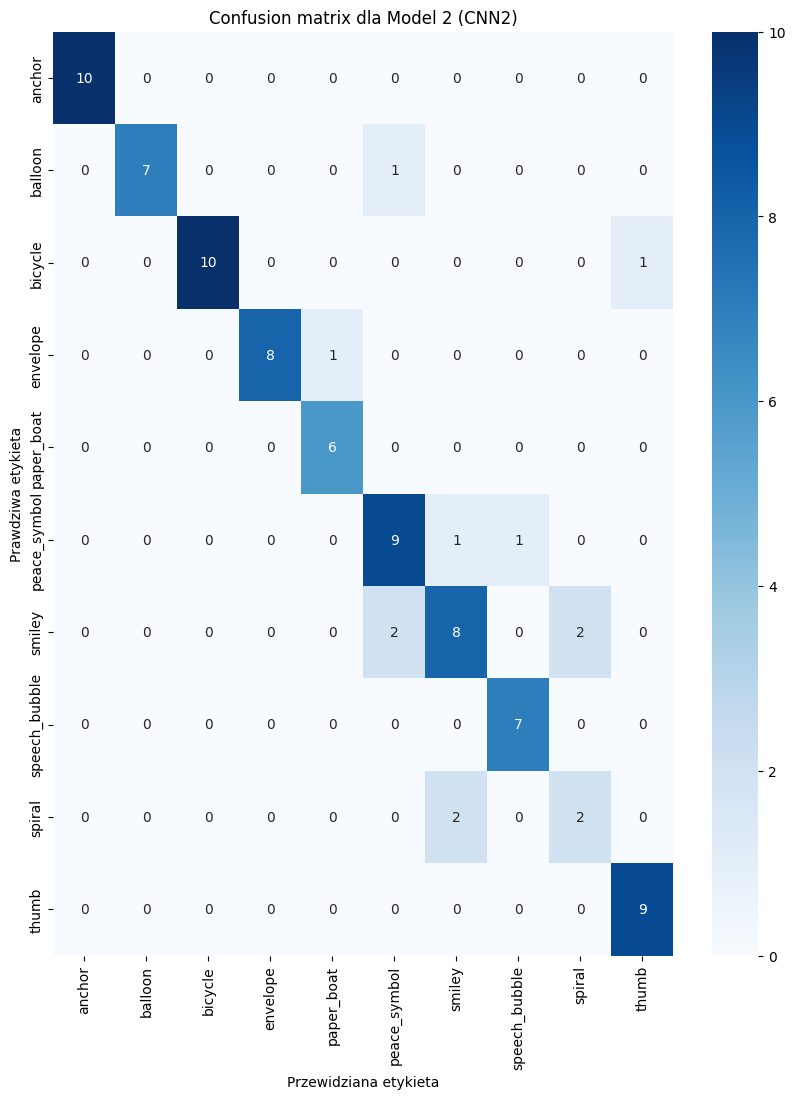

--- Ewaluacja dla: Model 3 (ResNet18) ---

Raport klasyfikacji:
               precision    recall  f1-score   support

       anchor       1.00      1.00      1.00        10
      balloon       1.00      0.88      0.93         8
      bicycle       1.00      1.00      1.00        11
     envelope       1.00      1.00      1.00         9
   paper_boat       0.86      1.00      0.92         6
 peace_symbol       0.92      1.00      0.96        11
       smiley       1.00      0.92      0.96        12
speech_bubble       1.00      1.00      1.00         7
       spiral       1.00      1.00      1.00         4
        thumb       1.00      1.00      1.00         9

     accuracy                           0.98        87
    macro avg       0.98      0.98      0.98        87
 weighted avg       0.98      0.98      0.98        87



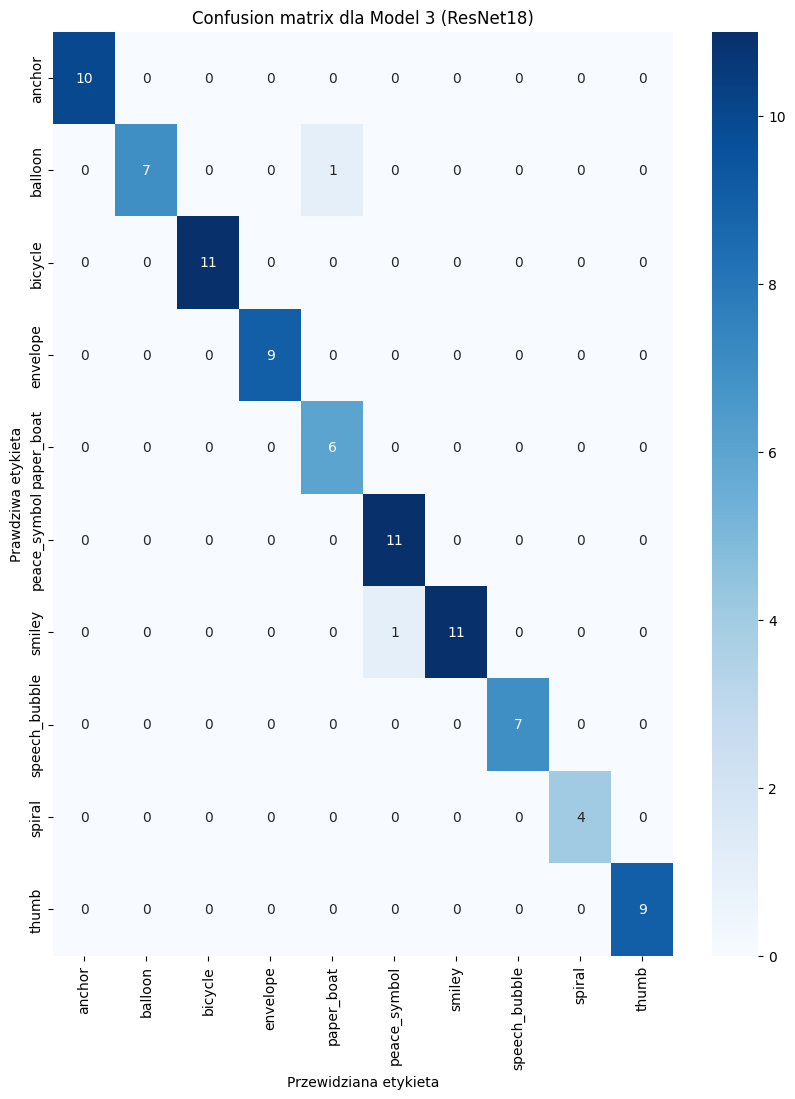

In [14]:
# ewaluacja modeli
evaluate_model(model1, test_loader_norm, "Model 1 (CNN1)")
evaluate_model(model2, test_loader_norm, "Model 2 (CNN2)")
evaluate_model(model3, test_loader_pretrained, "Model 3 (ResNet18)")

**Wyniki pokazały wyraźną progresję:**
* Prosty model CNN1 stanowił solidną bazę, ale miał trudności z niektórymi klasami
* Ulepszony CNN2 z batch normalization i dropoutem wykazał znaczącą poprawę
* Model oparty o transfer learning (ResNet18) okazał się zdecydowanie najskuteczniejszy, osiągając niemal bezbłędne wyniki i deklasując modele trenowane od zera

**Analiza Błędów**
* **Błędy modeli:** Słabością prostszych architektur było mylenie klas o podobnych cechach wizualnych (np. smiley, speech_bubble, spiral), co było widoczne na ich macierzach pomyłek. Model ResNet18 niemal całkowicie wyeliminował te problemy
* **Wyciek danych:** Początkowo prawdopodobnie niepoprawne podzielenie i użycie datasetu, co mogło doprowadzić do wycieku danych

**Miejsca do poprawy**

Chociaż osiągnięto bardzo dobre wyniki, istnieją dalsze możliwości progresji:
* **Augmentacja danych:** Zastosowanie technik takich jak losowe obroty czy zmiany jasności mogłyby jeszcze bardziej zwiększyć odporność modelu, nawet tego najlepszego
* **Eksperymenty z hiperparametrami:** Można by przetestować inne optymalizatory, wartości współczynnika uczenia czy większą liczbę epok treningowych

### Augmentacja danych
Ponownie wytrenujemy **Model 2 (CNN2)** na zbiorze z augmentacją. Wybraliśmy ten model, ponieważ jego wyniki nie były idealne, co stwarza przestrzeń do widocznej poprawy


In [36]:
# transformacja z augmentacją dla zbioru treningowego i walidacyjnego
transform_with_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

# zbiór testowy pozostawiamy bez augmentacji
transform_norm = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

In [37]:
full_ds_with_aug = torchvision.datasets.ImageFolder(root="data", transform=transform_with_aug)
train_val_ds_with_aug = torch.utils.data.Subset(full_ds_with_aug, train_val_ds.indices)

# te same indeksy co wcześniej
train_idx = train_ds_norm.indices

# zbiór treningowy z augmentacją, walidaycjny i testowy pozostają takie same
train_ds_aug = torch.utils.data.Subset(train_val_ds_with_aug, train_idx)

# tworzymy nowy loader
train_loader_aug = torch.utils.data.DataLoader(train_ds_aug, batch_size=64, shuffle=True, num_workers=0)

print(f"Nowy zbiór treningowy (z augmentacją): {len(train_ds_aug)} obrazków")

Nowy zbiór treningowy (z augmentacją): 276 obrazków


In [38]:
# training loop model 2 z augmentacją
model2_aug = CNN2(input_size=3, num_classes=len(class_names))
optimizer2_aug = torch.optim.Adam(model2_aug.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
epochs = 30

for epoch in range(epochs):
    model2_aug.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader_aug):
        outputs = model2_aug(images)
        loss = criterion(outputs, labels)

        optimizer2_aug.zero_grad()
        loss.backward()
        optimizer2_aug.step()
        train_loss += loss.item()

    model2_aug.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader_norm):
            outputs = model2_aug(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader_aug):.4f}, Val Loss: {val_loss/len(val_loader_norm):.4f}")

100%|██████████| 2/2 [00:00<00:00, 16.01it/s]


Epoch [1/30], Train Loss: 3.8778, Val Loss: 2.2486


100%|██████████| 2/2 [00:00<00:00, 16.02it/s]


Epoch [2/30], Train Loss: 3.2443, Val Loss: 1.8261


100%|██████████| 2/2 [00:00<00:00, 13.69it/s]


Epoch [3/30], Train Loss: 1.9690, Val Loss: 1.9343


100%|██████████| 2/2 [00:00<00:00, 15.00it/s]


Epoch [4/30], Train Loss: 1.5417, Val Loss: 1.5283


100%|██████████| 2/2 [00:00<00:00, 15.78it/s]


Epoch [5/30], Train Loss: 1.5516, Val Loss: 1.4586


100%|██████████| 2/2 [00:00<00:00, 14.73it/s]


Epoch [6/30], Train Loss: 1.1578, Val Loss: 1.4295


100%|██████████| 2/2 [00:00<00:00, 15.54it/s]


Epoch [7/30], Train Loss: 1.1342, Val Loss: 1.3171


100%|██████████| 2/2 [00:00<00:00, 14.44it/s]


Epoch [8/30], Train Loss: 0.9394, Val Loss: 1.2653


100%|██████████| 2/2 [00:00<00:00, 12.61it/s]


Epoch [9/30], Train Loss: 0.8411, Val Loss: 1.1675


100%|██████████| 2/2 [00:00<00:00, 13.75it/s]


Epoch [10/30], Train Loss: 0.8107, Val Loss: 0.9743


100%|██████████| 2/2 [00:00<00:00, 13.45it/s]


Epoch [11/30], Train Loss: 0.7465, Val Loss: 1.0332


100%|██████████| 2/2 [00:00<00:00, 15.85it/s]


Epoch [12/30], Train Loss: 0.7008, Val Loss: 1.0271


100%|██████████| 2/2 [00:00<00:00, 15.42it/s]


Epoch [13/30], Train Loss: 0.6299, Val Loss: 1.0932


100%|██████████| 2/2 [00:00<00:00, 14.41it/s]


Epoch [14/30], Train Loss: 0.5747, Val Loss: 0.6799


100%|██████████| 2/2 [00:00<00:00, 16.08it/s]


Epoch [15/30], Train Loss: 0.4890, Val Loss: 0.7521


100%|██████████| 2/2 [00:00<00:00, 15.82it/s]


Epoch [16/30], Train Loss: 0.4400, Val Loss: 0.9138


100%|██████████| 2/2 [00:00<00:00, 16.03it/s]


Epoch [17/30], Train Loss: 0.4548, Val Loss: 0.5543


100%|██████████| 2/2 [00:00<00:00, 15.09it/s]


Epoch [18/30], Train Loss: 0.3791, Val Loss: 0.5187


100%|██████████| 2/2 [00:00<00:00, 14.92it/s]


Epoch [19/30], Train Loss: 0.3473, Val Loss: 0.4896


100%|██████████| 2/2 [00:00<00:00, 14.04it/s]


Epoch [20/30], Train Loss: 0.2756, Val Loss: 0.4999


100%|██████████| 2/2 [00:00<00:00, 11.93it/s]


Epoch [21/30], Train Loss: 0.3388, Val Loss: 0.3853


100%|██████████| 2/2 [00:00<00:00, 13.07it/s]


Epoch [22/30], Train Loss: 0.3096, Val Loss: 0.3579


100%|██████████| 2/2 [00:00<00:00, 15.88it/s]


Epoch [23/30], Train Loss: 0.2877, Val Loss: 0.4303


100%|██████████| 2/2 [00:00<00:00, 15.65it/s]


Epoch [24/30], Train Loss: 0.2194, Val Loss: 0.3086


100%|██████████| 2/2 [00:00<00:00, 16.74it/s]


Epoch [25/30], Train Loss: 0.2286, Val Loss: 0.2842


100%|██████████| 2/2 [00:00<00:00, 15.44it/s]


Epoch [26/30], Train Loss: 0.2348, Val Loss: 0.2726


100%|██████████| 2/2 [00:00<00:00, 16.50it/s]


Epoch [27/30], Train Loss: 0.2071, Val Loss: 0.3139


100%|██████████| 2/2 [00:00<00:00, 15.48it/s]


Epoch [28/30], Train Loss: 0.1917, Val Loss: 0.3549


100%|██████████| 2/2 [00:00<00:00, 16.15it/s]


Epoch [29/30], Train Loss: 0.1484, Val Loss: 0.3257


100%|██████████| 2/2 [00:00<00:00,  9.32it/s]

Epoch [30/30], Train Loss: 0.1833, Val Loss: 0.2955


--- Ewaluacja dla: Model 2 (CNN2) z augmentacją ---

Raport klasyfikacji:
               precision    recall  f1-score   support

       anchor       1.00      1.00      1.00        10
      balloon       1.00      0.88      0.93         8
      bicycle       1.00      0.91      0.95        11
     envelope       0.90      1.00      0.95         9
   paper_boat       1.00      1.00      1.00         6
 peace_symbol       1.00      0.91      0.95        11
       smiley       1.00      0.92      0.96        12
speech_bubble       0.88      1.00      0.93         7
       spiral       0.67      1.00      0.80         4
        thumb       1.00      1.00      1.00         9

     accuracy                           0.95        87
    macro avg       0.94      0.96      0.95        87
 weighted avg       0.96      0.95      0.96        87



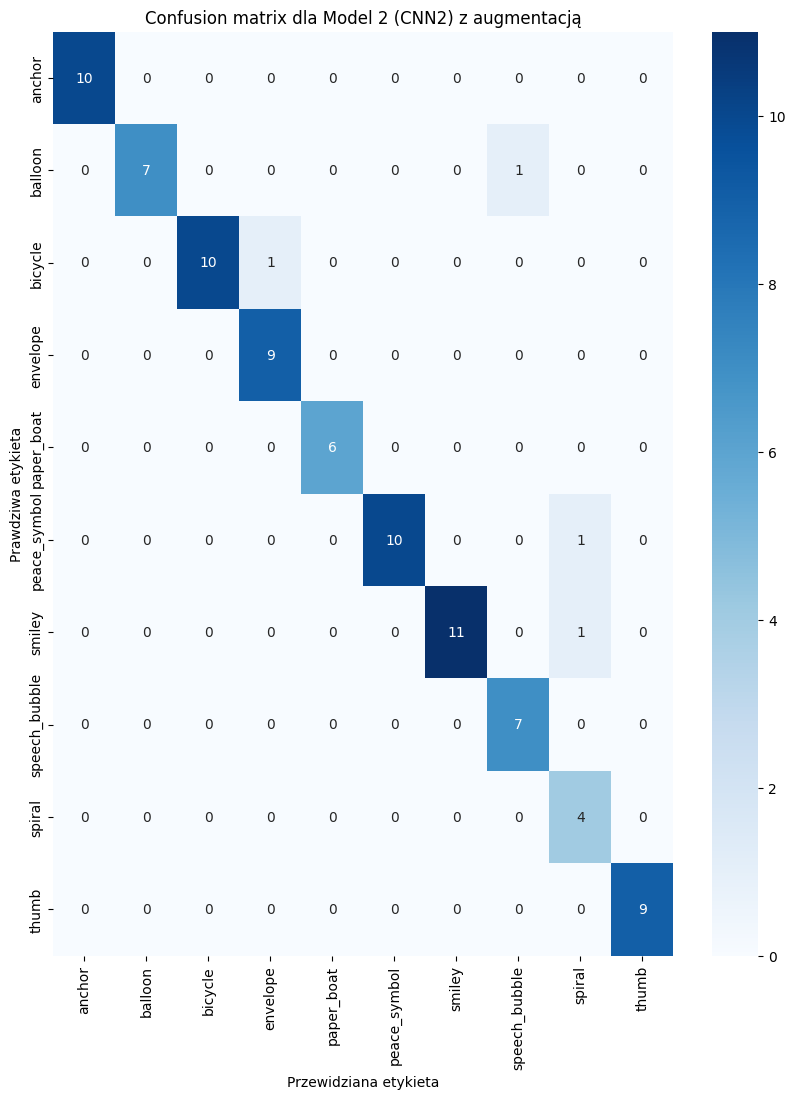

In [39]:
evaluate_model(model2_aug, test_loader_norm, "Model 2 (CNN2) z augmentacją")

Na podstawie przedstawionych wyników można wyciągnąć następujące wnioski:
* **Poprawa skuteczności:** Zastosowanie augmentacji danych przyniosło wyraźną poprawę we wszystkich kluczowych metrykach
* **Lepsza generalizacja:** Średni ważony F1-score podskoczył, co wskazuje, że model lepiej radzi sobie z klasyfikacją wszystkich kategorii, a nie tylko tych najłatwiejszych
* **Naprawa słabych punktów:** Augmentacja szczególnie pomogła w klasach, z którymi model miał największy problem, na przykład skuteczność dla klasy spiral oraz smiley wzrosła

To pokazuje, że augmentacja danych jest skuteczną techniką dla tego zbioru danych. Zwiększenie różnorodności obrazów treningowych pozwoliło modelowi lepiej generalizować na nowe dane.

### Activation maps (Grad-CAM)

Grad-CAM pozwala ona na stworzenie "mapy ciepła", która wizualizuje, które obszary na obrazie były dla modelu najważniejsze podczas klasyfikacji. Innymi słowy, możemy zobaczyć, na czym model "skupia swoją uwagę".

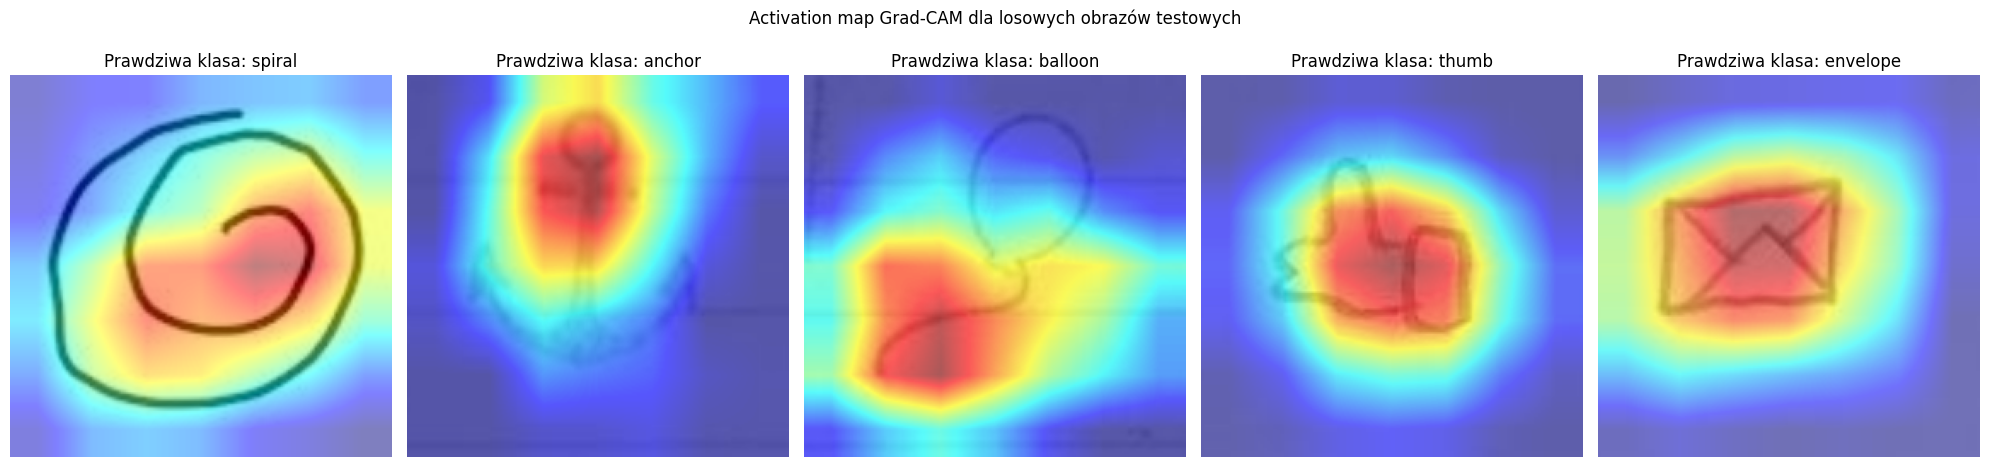

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

model_to_vis = model3
target_layer = [model_to_vis.layer4[-1].conv2]
n_img_to_show = 5

for param in model_to_vis.parameters():
    param.requires_grad = True

cam = GradCAM(model=model_to_vis, target_layers=target_layer)

fig, axes = plt.subplots(1, n_img_to_show, figsize=(20, 5))
fig.suptitle("Activation map Grad-CAM dla losowych obrazów testowych")

resize_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224)
])

ds = test_ds_pretrained
random_indices = np.random.choice(len(ds), n_img_to_show, replace=False)

for i, local_idx in enumerate(random_indices):
    input_tensor, label_idx = ds[local_idx]

    base = ds.dataset
    path, true_label = base.samples[ds.indices[local_idx]]
    original_pil_img = Image.open(path).convert("RGB")

    input_tensor_batch = input_tensor.unsqueeze(0)

    targets = [ClassifierOutputTarget(label_idx)]
    grayscale_cam = cam(input_tensor=input_tensor_batch, targets=targets)[0]

    rgb_img_float = np.array(resize_transform(original_pil_img)) / 255.0
    vis = show_cam_on_image(rgb_img_float, grayscale_cam, use_rgb=True)

    ax = axes[i]
    ax.imshow(vis)
    ax.set_title(f"Prawdziwa klasa: {base.classes[true_label]}")
    ax.axis('off')

plt.tight_layout()
plt.savefig("figures/activation-maps.png")
plt.show()

Na podstawie wygenerowanych map aktywacji można wyciągnąć następujące wnioski:

* **Model nauczył się poprawnych cech:** Wizualizacje pokazują, że model w większości przypadków skupia swoją uwagę na charakterystycznych i istotnych częściach rysunku, a nie na tle czy przypadkowych elementach, na przykład dla klasy smiley aktywacja koncentruje się na oczach i uśmiechu
* **Potwierdzenie wysokiej skuteczności:** Taka interpretowalność daje nam pewność, że wysoka dokładność modelu nie jest dziełem przypadku, model nie nauczył się jakichś nieistotnych korelacji (np. koloru tła), ale faktycznie rozpoznaje kluczowe cechy obiektów na rysunkach
* **Potencjalne słabości:** W niektórych przypadkach (np. balloon) aktywacje są mniej precyzyjne i rozproszone. Może to sugerować, że cechy tych obiektów są mniej jednoznaczne, ale mimo to model był w stanie dokonać poprawnej klasyfikacji

In [ ]:
torch.save(model3.state_dict(), 'resnet18.pth')